# Clustering RAJA Performance Suite Dataset: Thicket Tutorial

Thicket is a python-based toolkit for Exploratory Data Analysis (EDA) of parallel performance data that enables performance optimization and understanding of applications’ performance on supercomputers. It bridges the performance tool gap between being able to consider only a single instance of a simulation run (e.g., single platform, single measurement tool, or single scale) and finding actionable insights in multi-dimensional, multi-scale, multi-architecture, and multi-tool performance datasets.

**NOTE: An interactive version of this notebook is available in the Binder environment.**

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/llnl/thicket-tutorial/develop)

***

## 1. Import Necessary Packages

In [1]:
import os
import sys
import re
from itertools import product

from IPython.display import display
from IPython.display import HTML
from IPython.display import Markdown
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import hatchet as ht
from hatchet import QueryMatcher

import thicket as th
from thicket import Thicket

<IPython.core.display.Javascript object>

Disable the absurd number of warnings that NumPy will produce:

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## 2. Utility Functions for Ingesting and Manipulating Performance Data

In [3]:
def get_perf_leaves(thicket):
    """Get data associated with only the leaf nodes of the thicket.
    
    Keyword Arguments:
    thicket -- thicket object
    """
    query = QueryMatcher().match(
        ".",
        lambda row: len(row.index.get_level_values("node")[0].children) == 0
    )
    new_thicket = thicket.copy()
    matches = query.apply(thicket)
    idx_names = new_thicket.dataframe.index.names
    new_thicket.dataframe.reset_index(inplace=True)
    new_thicket.dataframe = new_thicket.dataframe.loc[new_thicket.dataframe["node"].isin(matches)]
    new_thicket.dataframe.set_index(idx_names, inplace=True)
    squashed_gf = new_thicket.squash()
    new_thicket.graph = squashed_gf.graph
    new_thicket.statsframe.graph = squashed_gf.graph
    
    # NEW: need to update the performance data and the statsframe with the remaining (re-indexed) nodes.
    # The dataframe is internally updated in squash(), so we can easily just save it to our thicket perfdata.
    # For the statsframe, we'll have to come up with a better way eventually, but for now, we'll just create
    #    a new statsframe the same way we do when we create a new thicket. 
    new_thicket.dataframe = squashed_gf.dataframe    
    subset_df = new_thicket.dataframe["name"].reset_index().drop_duplicates(subset=["node"])
    new_thicket.statsframe = ht.GraphFrame(
        graph=squashed_gf.graph,
        dataframe=pd.DataFrame(
            index=subset_df["node"],
            data={"name": subset_df["name"].values},
        ),
    )
    return new_thicket

def apply_query_to_thicket(thicket, query):
    """Applies query to thicket object.
    
    Keyword Arguments:
    thicket -- thicket object
    query -- thicket query
    """
    new_thicket = thicket.copy()
    matches = query.apply(thicket)
    idx_names = new_thicket.dataframe.index.names
    new_thicket.dataframe.reset_index(inplace=True)
    new_thicket.dataframe = new_thicket.dataframe.loc[new_thicket.dataframe["node"].isin(matches)]
    new_thicket.dataframe.set_index(idx_names, inplace=True)
    squashed_gf = new_thicket.squash()
    new_thicket.graph = squashed_gf.graph
    new_thicket.statsframe.graph = squashed_gf.graph
    
    # NEW: need to update the performance data and the statsframe with the remaining (re-indexed) nodes.
    # The dataframe is internally updated in squash(), so we can easily just save it to our thicket perfdata.
    # For the statsframe, we'll have to come up with a better way eventually, but for now, we'll just create
    #    a new statsframe the same way we do when we create a new thicket. 
    new_thicket.dataframe = squashed_gf.dataframe    
    subset_df = new_thicket.dataframe["name"].reset_index().drop_duplicates(subset=["node"])
    new_thicket.statsframe = ht.GraphFrame(
        graph=squashed_gf.graph,
        dataframe=pd.DataFrame(
            index=subset_df["node"],
            data={"name": subset_df["name"].values},
        ),
    )
    return new_thicket

def get_node(thicket, node_name):
    """Get data associated with only the node corresponding to node_name.
    
    Keyword Arguments:
    thicket -- thicket object
    node_name -- (str) name of a node
    """
    query = QueryMatcher().match(
        ".",
        lambda row: row.index.get_level_values("node")[0].frame["name"] == node_name
    )        

    return apply_query_to_thicket(thicket, query)

def get_nodes_in_group(thicket, group_prefix):
    """Get data associated with kernels with the specified name prefix
    
    Keyword Arguments:
    thicket -- thicket object
    group_prefix -- prefix to satisfy startswith condition
    """
    nodes_thicket = get_perf_leaves(thicket)
    query = QueryMatcher().match(
        ".",
        lambda row: row.index.get_level_values("node")[0].frame["name"].startswith(group_prefix)
    )
    return apply_query_to_thicket(nodes_thicket, query)

In [4]:
def check_for_optimization_level(val):
    match = re.search(r"(?P<opt_level>-O[0123]).*", val)
    if match is None:
        raise ValueError("Could not find opt level in {}".format(val))
    return match.group("opt_level")

def check_for_optimization_level_int(val):
    match = re.search(r"-O(?P<opt_level>[0-3]).*", val)
    if match is None:
        raise ValueError("Could not find opt level in {}".format(val))
    return match.group("opt_level")

def add_metadata_to_thicket(thicket):
    """Insert additional metadata columns to the performance data table.
    
    Keyword Arguments:
    thicket -- thicket object
    """
    thicket.metadata["opt_level"] = thicket.metadata["rajaperf_compiler_options"].apply(
        check_for_optimization_level
    )
    thicket.metadata["opt_level_int"] = thicket.metadata["rajaperf_compiler_options"].apply(
        check_for_optimization_level_int
    )
    thicket.metadata_column_to_perfdata("opt_level")
    thicket.metadata_column_to_perfdata("opt_level_int")
    thicket.metadata_column_to_perfdata("compiler")
    return ["opt_level", "opt_level_int", "compiler"], thicket

In [5]:
def collect_ensemble_data(directories, metrics, exc_time_metric="time (exc)", profile_level_name="profile"):
    """Create a thicket from multiple profiles with specified metric columns.
    
    Keyword Arguments:
    directories -- list of paths to profiles
    metrics -- perf metrics
    """
    real_metrics = metrics.copy()
    if "name" not in real_metrics:
        real_metrics.append("name")
    if "nid" not in real_metrics:
        real_metrics.append("nid")
    if exc_time_metric not in real_metrics:
        real_metrics.append(exc_time_metric)
    subthickets = []
    for directory in directories:
        thicket = Thicket.from_caliperreader(directory)
        thicket.dataframe = thicket.dataframe[[*real_metrics]]
        thicket.exc_metrics = [m for m in thicket.dataframe.columns if m in thicket.exc_metrics]
        thicket.inc_metrics = [m for m in thicket.dataframe.columns if m in thicket.inc_metrics]
        if thicket.default_metric not in thicket.dataframe.columns:
            if exc_time_metric in thicket.dataframe.columns:
                thicket.default_metric = exc_time_metric
            else:
                raise ValueError("Could not set default metric")
        subthickets.append(thicket)
    return Thicket.concat_thickets(axis="index", thickets=subthickets)

In [6]:
def calc_speedup_by_opt_level(df, opt_level_metric="opt_level", name_metric="name",
                              exc_time_metric="time (exc)", min_opt_level="-O0"):
    """Calculate speedup based on optimization level (e.g., O0/O1, O0/O2, etc.).
    
    Keyword Arguments:
    df -- performace data table
    """
    index_names = df.index.names
    df.reset_index(inplace=True)
    min_opt_groups = df.groupby(
        by=name_metric
    )
    min_opt_times = {}
    for group_name, group in min_opt_groups:
        min_time = group.loc[group[opt_level_metric] == min_opt_level, exc_time_metric].iloc[0]
        min_opt_times[group_name] = min_time
        
    def calc_speedup(row):
        base_time = min_opt_times[row[name_metric]]
        ret_val = base_time / row[exc_time_metric]
        return ret_val
    
    speedup_col = df.apply(calc_speedup, axis="columns")
    df["speedup"] = speedup_col
    
    df.set_index(index_names, inplace=True)
    
    return df

## 3. Utility Functions for KMeans

In [7]:
def build_clustering_df(gf, metrics):
    tmp_df = gf.dataframe.reset_index()
    real_metrics = metrics
    if "name" in tmp_df.columns and "name" not in metrics:
        real_metrics.append("name")
    return tmp_df[[*metrics]]

In [8]:
def normalize_data(df, metrics, **kwargs):
    """Creates normalized versions of the specified metrics.
    
    Keyword Arguments:
    df -- performace data table
    metrics -- perf metrics
    """
    scaler = StandardScaler()
    data = df[[*metrics]].to_numpy()
    new_data = scaler.fit_transform(data)
    for col in range(new_data.shape[1]):
        df["{}_norm".format(metrics[col])] = new_data[:, col]
    return df


def cluster_data(df, x_metric, y_metric, n_clusters=8, use_y_for_label=True):
    """Conducts a KMeans clustering of data from the DataFrame.
    
    Keyword Arguments:
    df -- performace data table
    n_clusters -- no. of clusters
    """
    print(x_metric, y_metric)
    km = KMeans(n_clusters=n_clusters)
    pts = df[[x_metric, y_metric]].to_numpy()
    cluster_labels = km.fit_predict(pts)
    label_metric = y_metric if use_y_for_label else x_metric
    if label_metric.endswith("_norm"):
        label_metric = label_metric[:-len("_norm")]
    cluster_label = "clusters" if label_metric.startswith("pca") else "{}_cluster".format(label_metric)
    df["{}_id".format(cluster_label)] = cluster_labels
    df[cluster_label] = ["Cluster {}".format(l) for l in cluster_labels]
    return cluster_label, km.cluster_centers_, df

In [9]:
# Modified version of the code from
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
def silhouette_test(df, x_metric, y_metric):
    """Silhouette analysis on KMeans clustering.
    
    Keyword Arguments:
    df -- performace data table
    """
    range_n_clusters = [2, 3, 4, 5, 6]
    
    pts = df[[x_metric, y_metric]].to_numpy()

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(pts) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(pts)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(pts, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(pts, cluster_labels)
        
        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            pts[:, 0], pts[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

In [10]:
def plot_clusters(df, x_metric, y_metric, hue_metric, marker_style_metric=None, 
                  swap_marker_and_hue=False, cluster_centers=None, use_y_for_label=True,
                  **kwargs):
    """Plot cluster with specific configuration.
    
    Keyword Arguments:
    df -- performace data table
    """
    hue = hue_metric
    df = df.sort_values(
        [
            "opt_level_int",
            hue
        ],
    )
    ax = None
    if marker_style_metric is not None:
        if swap_marker_and_hue:
            hue_order = sorted(df[marker_style_metric].unique().tolist())
            style_order = sorted(df[hue].unique().tolist())
            ax = sns.scatterplot(
                data=df,
                x=x_metric,
                y=y_metric,
                hue=marker_style_metric,
                style=hue,
                legend="auto",
                hue_order=hue_order,
                style_order=style_order,
                **kwargs
            )
        else:
            hue_order = sorted(df[hue].unique().tolist())
            style_order = sorted(df[marker_style_metric].unique().tolist())
            ax = sns.scatterplot(
                data=df,
                x=x_metric,
                y=y_metric,
                hue=hue,
                style=marker_style_metric,
                legend="auto",
                hue_order=hue_order,
                style_order=style_order,
                **kwargs
            )
    else:
        hue_order = sorted(df[hue].unique().tolist())
        ax = sns.scatterplot(
            data=df,
            x=x_metric,
            y=y_metric,
            hue=hue,
            legend="auto",
            hue_order=hue_order,
            **kwargs
        )
    return ax

In [11]:
def plot_lines_by_profile(df, x_metric, y_metric, grouping_metric, axes, legend="auto"):
    """Plot line with specific configuration."""
    sns.lineplot(data=df, x=x_metric, y=y_metric, style=grouping_metric, ax=axes, legend=legend, color="#c0c0c0")

## 4. Set Variables to be Used for All Clustering

Set `directories` to be a list of the directories containing the `.cali` files to load

In [12]:
root = "../data/quartz"
dirs_ordered = [
    "GCC_10.3.1_BaseSeq_08388608/O0/GCC_1031_BaseSeq_O0_8388608_01.cali",
    "GCC_10.3.1_BaseSeq_08388608/O1/GCC_1031_BaseSeq_O1_8388608_01.cali",
    "GCC_10.3.1_BaseSeq_08388608/O2/GCC_1031_BaseSeq_O2_8388608_01.cali",
    "GCC_10.3.1_BaseSeq_08388608/O3/GCC_1031_BaseSeq_O3_8388608_01.cali"
]
directories = ["{}/{}".format(root, d) for d in dirs_ordered]

Set `topdown_cols` to be a list containing the Topdown metrics to be used

In [13]:
topdown_cols=[
    "Retiring",
    "Frontend bound",
    "Backend bound",
    "Bad speculation",
]

## 5. Thicket Clustering

Collect the performance data from Quartz. Then, normalize and cluster the 4 high-level topdown metrics (i.e., retiring, frontend bound, backend bound, and bad speculation) with respect to time. Finally, plot the clusters and produce a dataframe containing the node name, metrics, cluster ID, and optimization level.

Set variables used for clustering:

In [14]:
# If desired, set max_time_variance_node to the node to focus on for the clustering
max_time_variance_node = "Polybench_FLOYD_WARSHALL.default"
# Specify the number of clusters to create for each topdown metric
n_clusters_retiring = 3
n_clusters_frontend_bound = 4
n_clusters_backend_bound = 3
n_clusters_bad_speculation = 4
# If desired, scale the topdown metrics by this factor before clustering
topdown_scaling_factor = 1
# If true, use sklearn's StandardScaler to create normalized metrics
use_normalization = True

Read data into a single Thicket

In [15]:
thicket = collect_ensemble_data(directories, topdown_cols)

/opt/conda/lib/python3.9/site-packages/thicket/ensemble.py:319: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  perfdata[col].replace({fill_value: None}, inplace=True)


**NOTE:** Only run one of the next three cells

Cell 1: Query the Thicket object to get data associated with only the node corresponding to `max_time_variance_node`

Cell 2: Query the Thicket object to get data associated with only the leaf nodes

Cell 3: Query the Thicket object to get data associated with kernels with the specified name prefix

In [16]:
single_node_thicket = get_node(thicket, max_time_variance_node)

In [17]:
single_node_thicket = get_perf_leaves(thicket)

In [18]:
single_node_thicket = get_nodes_in_group(thicket, "Stream")

Add important metadata columns into the performance data

In [19]:
metadata_cols, single_node_thicket = add_metadata_to_thicket(single_node_thicket)

Calculate speedup based on optimization level (e.g., O0/O1, O0/O2, etc.)

In [20]:
single_node_thicket.dataframe = calc_speedup_by_opt_level(single_node_thicket.dataframe)

Extract the important data into a DataFrame better formatted for clustering

In [21]:
df = build_clustering_df(single_node_thicket, metadata_cols + topdown_cols + ["speedup"])
df

,opt_level,opt_level_int,compiler,Retiring,Frontend bound,Backend bound,Bad speculation,speedup,name
0,-O0,0,g++-10.3.1,0.057756,0.007283,0.934745,0.000215,1.000000,Stream_ADD
1,-O2,2,g++-10.3.1,0.056447,0.006957,0.936493,0.000103,1.015401,Stream_ADD
2,-O1,1,g++-10.3.1,0.056757,0.007064,0.936231,0.000000,1.007056,Stream_ADD
3,-O3,3,g++-10.3.1,0.056902,0.006809,0.935997,0.000292,0.994071,Stream_ADD
4,-O0,0,g++-10.3.1,0.050230,0.000932,0.948421,0.000417,1.000000,Stream_COPY
5,-O2,2,g++-10.3.1,0.050511,0.000783,0.948439,0.000267,1.022479,Stream_COPY
6,-O1,1,g++-10.3.1,0.050061,0.000932,0.948870,0.000137,1.004292,Stream_COPY
7,-O3,3,g++-10.3.1,0.050100,0.000739,0.949018,0.000143,0.998211,Stream_COPY
8,-O0,0,g++-10.3.1,0.085235,0.009152,0.905275,0.000337,1.000000,Stream_DOT
9,-O2,2,g++-10.3.1,0.083024,0.009174,0.907857,0.000000,1.005844,Stream_DOT


**This cell is optional!**

If desired, run this cell to create normalized versions of the specified metrics

In [22]:
df = normalize_data(df, topdown_cols + ["speedup"])
df

,opt_level,opt_level_int,compiler,Retiring,Frontend bound,Backend bound,Bad speculation,speedup,name,Retiring_norm,Frontend bound_norm,Backend bound_norm,Bad speculation_norm,speedup_norm
0,-O0,0,g++-10.3.1,0.057756,0.007283,0.934745,0.000215,1.000000,Stream_ADD,-0.451957,0.357531,0.304406,0.187331,-0.566466
1,-O2,2,g++-10.3.1,0.056447,0.006957,0.936493,0.000103,1.015401,Stream_ADD,-0.562996,0.242517,0.428783,-0.694227,0.994632
2,-O1,1,g++-10.3.1,0.056757,0.007064,0.936231,0.000000,1.007056,Stream_ADD,-0.536700,0.280267,0.410141,-1.504945,0.148736
3,-O3,3,g++-10.3.1,0.056902,0.006809,0.935997,0.000292,0.994071,Stream_ADD,-0.524400,0.190302,0.393491,0.793402,-1.167452
4,-O0,0,g++-10.3.1,0.050230,0.000932,0.948421,0.000417,1.000000,Stream_COPY,-1.090369,-1.883123,1.277513,1.777283,-0.566466
5,-O2,2,g++-10.3.1,0.050511,0.000783,0.948439,0.000267,1.022479,Stream_COPY,-1.066533,-1.935691,1.278794,0.596626,1.711995
6,-O1,1,g++-10.3.1,0.050061,0.000932,0.948870,0.000137,1.004292,Stream_COPY,-1.104705,-1.883123,1.309461,-0.426611,-0.131445
7,-O3,3,g++-10.3.1,0.050100,0.000739,0.949018,0.000143,0.998211,Stream_COPY,-1.101397,-1.951214,1.319992,-0.379385,-0.747844
8,-O0,0,g++-10.3.1,0.085235,0.009152,0.905275,0.000337,1.000000,Stream_DOT,1.879020,1.016920,-1.792514,1.147599,-0.566466
9,-O2,2,g++-10.3.1,0.083024,0.009174,0.907857,0.000000,1.005844,Stream_DOT,1.691466,1.024682,-1.608793,-1.504945,0.025889


Cluster the topdown metrics with respect to exclusive time.

If `topdown_scaling_factor` is set to any value besides 1, the topdown metrics will be multiplied by that value before clustering and divided by that value after clustering.

If `use_normalization` is true, use the normalized metrics calculated by `normalize_data` for clustering instead of the vanilla versions.

If `silhouette_mode` (in the next cell) is true, don't cluster. Instead run a Silhouette analysis on the data to find the correct K values.

In [23]:
silhouette_mode = False

In [24]:
cluster_centers = []
cluster_labels = []
pairs = list(product(["speedup"], topdown_cols))
for x, y in pairs:
    nc = 8
    if y == "Retiring":
        nc = n_clusters_retiring
    elif y == "Frontend bound":
        nc = n_clusters_frontend_bound
    elif y == "Backend bound":
        nc = n_clusters_backend_bound
    elif y == "Bad speculation":
        nc = n_clusters_bad_speculation
    df[y] = df[y] * topdown_scaling_factor
    if silhouette_mode:
        x_met = x
        y_met = y
        if use_normalization:
            x_met = "{}_norm".format(x_met)
            y_met = "{}_norm".format(y_met)
        print("Printing Silhouette Test for: {} vs {}".format(x_met, y_met), end="\n\n")
        silhouette_test(df, x_met, y_met)
    else:
        if use_normalization:
            clab, cc, df = cluster_data(df, "{}_norm".format(x), "{}_norm".format(y), n_clusters=nc)
        else:
            clab, cc, df = cluster_data(df, x, y, n_clusters=nc)
        df[y] = df[y] / topdown_scaling_factor
        cc = [(sc[0], sc[1]/topdown_scaling_factor) for sc in cc]
        cluster_centers.append(cc)
        cluster_labels.append(clab)

speedup_norm Retiring_norm
speedup_norm Frontend bound_norm
speedup_norm Backend bound_norm
speedup_norm Bad speculation_norm


These two cells simply print out the post-clustering DataFrame and the centroids

In [25]:
df.sort_values(by=["name", "speedup"])

,opt_level,opt_level_int,compiler,Retiring,Frontend bound,Backend bound,Bad speculation,speedup,name,Retiring_norm,...,Bad speculation_norm,speedup_norm,Retiring_cluster_id,Retiring_cluster,Frontend bound_cluster_id,Frontend bound_cluster,Backend bound_cluster_id,Backend bound_cluster,Bad speculation_cluster_id,Bad speculation_cluster
3,-O3,3,g++-10.3.1,0.056902,0.006809,0.935997,0.000292,0.994071,Stream_ADD,-0.524400,...,0.793402,-1.167452,2,Cluster 2,3,Cluster 3,2,Cluster 2,1,Cluster 1
0,-O0,0,g++-10.3.1,0.057756,0.007283,0.934745,0.000215,1.000000,Stream_ADD,-0.451957,...,0.187331,-0.566466,2,Cluster 2,3,Cluster 3,2,Cluster 2,1,Cluster 1
2,-O1,1,g++-10.3.1,0.056757,0.007064,0.936231,0.000000,1.007056,Stream_ADD,-0.536700,...,-1.504945,0.148736,2,Cluster 2,3,Cluster 3,2,Cluster 2,0,Cluster 0
1,-O2,2,g++-10.3.1,0.056447,0.006957,0.936493,0.000103,1.015401,Stream_ADD,-0.562996,...,-0.694227,0.994632,1,Cluster 1,2,Cluster 2,1,Cluster 1,2,Cluster 2
7,-O3,3,g++-10.3.1,0.050100,0.000739,0.949018,0.000143,0.998211,Stream_COPY,-1.101397,...,-0.379385,-0.747844,2,Cluster 2,1,Cluster 1,2,Cluster 2,0,Cluster 0
4,-O0,0,g++-10.3.1,0.050230,0.000932,0.948421,0.000417,1.000000,Stream_COPY,-1.090369,...,1.777283,-0.566466,2,Cluster 2,1,Cluster 1,2,Cluster 2,1,Cluster 1
6,-O1,1,g++-10.3.1,0.050061,0.000932,0.948870,0.000137,1.004292,Stream_COPY,-1.104705,...,-0.426611,-0.131445,2,Cluster 2,1,Cluster 1,2,Cluster 2,0,Cluster 0
5,-O2,2,g++-10.3.1,0.050511,0.000783,0.948439,0.000267,1.022479,Stream_COPY,-1.066533,...,0.596626,1.711995,1,Cluster 1,1,Cluster 1,1,Cluster 1,3,Cluster 3
11,-O3,3,g++-10.3.1,0.084316,0.009045,0.906415,0.000224,0.991317,Stream_DOT,1.801063,...,0.258170,-1.446604,0,Cluster 0,0,Cluster 0,0,Cluster 0,1,Cluster 1
8,-O0,0,g++-10.3.1,0.085235,0.009152,0.905275,0.000337,1.000000,Stream_DOT,1.879020,...,1.147599,-0.566466,0,Cluster 0,0,Cluster 0,0,Cluster 0,1,Cluster 1


In [26]:
cluster_centers

[[(-0.4881578350674403, 1.1627113660348523),
  (1.749806261598802, -0.4525719966261081),
  (-0.3980133556581501, -0.7031879528599482)],
 [(-0.5369190461812909, 1.0233588678009826),
  (0.06655968097162471, -1.913287530716048),
  (1.762410152328975, 0.26544919660540234),
  (-0.37842144401649835, 0.3070407846493405)],
 [(-0.5369190461812909, -1.704780673615863),
  (1.749806261598802, 0.4371796258076567),
  (-0.4042957384725225, 0.42253368260272484)],
 [(-0.12896575481965436, -1.038303837050783),
  (-0.6773849736286504, 0.8537464731912041),
  (1.4144833729601425, -0.7611304605801118),
  (2.085129150237462, 0.5533347608974337)]]

## 6. Plot the Clusters as Scatterplots

The legends will not be printed, but they will be dumped to file.

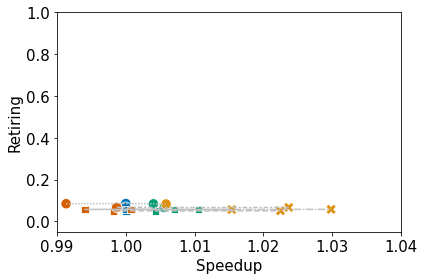

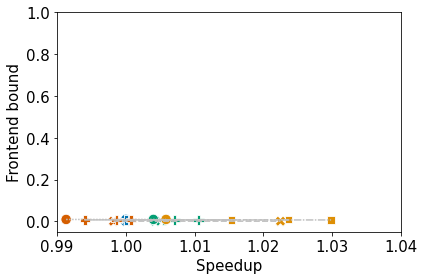

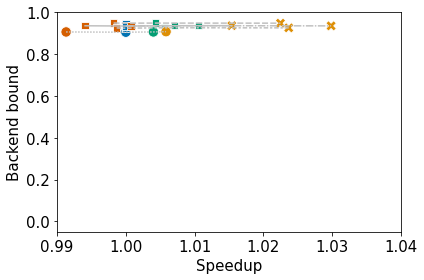

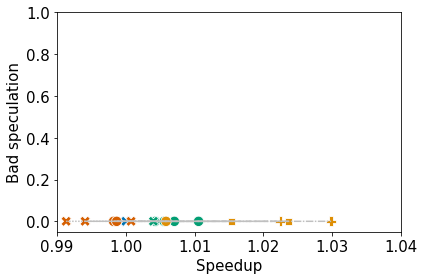

In [27]:
sns_handles = None
sns_labels = None

is_first = True

for clab, mets, ccs in zip(cluster_labels, pairs, cluster_centers):
    scatter_palette = sns.color_palette("colorblind", n_colors=4).as_hex()
    tmp = scatter_palette[1]
    scatter_palette[1] = scatter_palette[2]
    scatter_palette[2] = tmp
    ax = plot_clusters(df, mets[0], mets[1], hue_metric="opt_level",
                       marker_style_metric="{}_cluster".format(mets[1]), swap_marker_and_hue=False,
                       palette=scatter_palette, s=3*mpl.rcParams["lines.markersize"]**2,
    )
    ax.tick_params(axis="both", which="major", labelsize=1.5*ax.get_xticklabels()[0].get_fontsize())
    xlab = ax.xaxis.get_label()
    ax.set_xlabel(
        "Speedup",#xlab.get_text(),
        fontfamily=xlab.get_fontfamily(),
        fontsize=1.5*xlab.get_fontsize(),
        fontstyle=xlab.get_fontstyle(),
        fontvariant=xlab.get_fontvariant(),
        fontweight=xlab.get_fontweight(),
    )
    ylab = ax.yaxis.get_label()
    ax.set_ylabel(
        ylab.get_text(),
        fontfamily=ylab.get_fontfamily(),
        fontsize=1.5*ylab.get_fontsize(),
        fontstyle=ylab.get_fontstyle(),
        fontvariant=ylab.get_fontvariant(),
        fontweight=ylab.get_fontweight(),
    )
    ax.set_xlim(0.99, 1.04)
    ax.set_ylim(-0.05, 1.0)
    plot_lines_by_profile(df, mets[0], mets[1], "name", ax)
    legend = ax.legend(loc="center left", bbox_to_anchor=(1.25, 0.5), ncol=2)
    legend.get_texts()[0].set_text("Optimization Level")
    legend.get_texts()[5].set_text("Clusters")
    legend_fig = legend.figure
    legend_fig.canvas.draw()
    bbox = legend.get_window_extent().transformed(legend_fig.dpi_scale_trans.inverted())
    legend.remove()
    plt.tight_layout()
    if is_first:
        sns_handles, sns_labels = ax.get_legend_handles_labels()
        is_first = False
    plt.show()